# PF-MCMC Implementation with Python

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from scipy.integrate import odeint

In [17]:
def SUIRD_model(params, previous_state, N):
    alpha, beta, gamma, mu= params
    S, U, I, R, D = previous_state

    for i in range(t):
        dS = -(beta * S * U)/ N
        dU =  (beta * S * U)/ N - (alpha * U) - (gamma * U) - (mu * U)
        dI = alpha * U - (gamma * I) - (mu * I)
        dR = gamma * U + (gamma * I)
        dD = mu * U + (mu * I)
        
        S_n = S + dS
        U_n = U + dU
        I_n= I + dI
        R_n = R+  dR
        D_n = D + dD

    return [S_n, U_n, I_n, R_n, D_n]

In [4]:
# Initial state
N =  10000
U0 =  stats.uniform(500,1000).rvs(1)[0]     # Initial undetected infected population
S0 = N - U0   # Initial susceptible population
I0 = 0       # Initial infected population
R0 = 0      # Initial recovered population
D0 = 0      # Initial deceased population

states_0 = np.array([S0, U0, I0, R0, D0], dtype='float64')

param_means = [0.1, 0.3, 0.07, 0.01]
param_stds = [0.01, 0.02, 0.005, 0.005]

alpha = stats.truncnorm(0.01, 0.99, param_means[0], param_stds[0],).rvs()
beta = stats.truncnorm(0.01, 0.99, param_means[1], param_stds[1],).rvs()
gamma = stats.truncnorm(0.01, 0.99, param_means[2], param_stds[2],).rvs()
mu = stats.truncnorm(0.01, 0.99, param_means[3], param_stds[3],).rvs()

params_0 = np.array([alpha, beta, gamma, mu], dtype='float64')

T = 50

states_history = np.zeros((len(states_0),T))
params_history = np.zeros((len(params_0),T))

states_history[:,0] = states_0
params_history[:,0] = params_0

for t in range(1,T):
    S,U,I,R,D = SUIRD_model(params_history[:,t-1], states_history[:,t-1], N)
    states = np.array([S,U,I,R,D])
    # Sample parameters
    alpha = stats.norm(params_history[0, t-1], param_stds[0]).rvs()
    beta = stats.norm(params_history[1, t-1], param_stds[1]).rvs()
    gamma = stats.norm(params_history[2, t-1], param_stds[2]).rvs()
    mu = stats.norm(params_history[3, t-1], param_stds[3]).rvs()
    params = np.array([alpha, beta, gamma, mu])
    
    states_history[:,t] = states
    params_history[:,t] = params

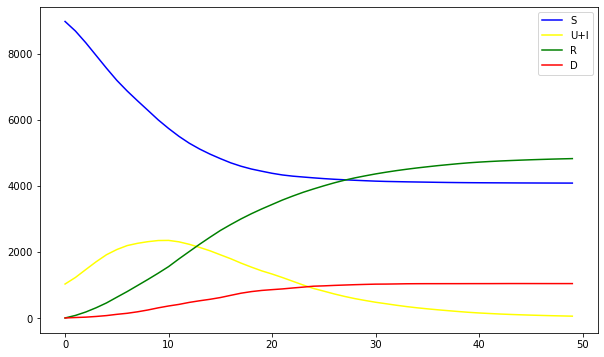

In [5]:
plt.figure(figsize=(10,6))
plt.plot(range(0,T), states_history[0,:], label='S', color='blue')
plt.plot(range(0,T), states_history[1,:]+states_history[2,:], label='U+I', color='yellow')
#plt.plot(range(0,T), states_history[2,:], label='I', color='orange')
plt.plot(range(0,T), states_history[3,:], label='R', color='green')
plt.plot(range(0,T), states_history[4,:], label='D', color='red')
plt.legend()
plt.show()

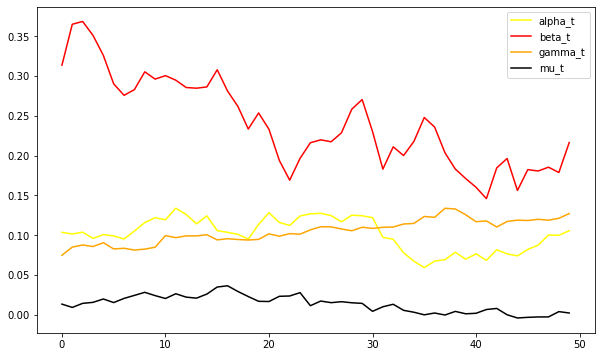

In [6]:
plt.figure(figsize=(10,6))
plt.plot(range(0,T), params_history[0,:], label='alpha_t', color='yellow')
plt.plot(range(0,T), params_history[1,:], label='beta_t', color='red')
plt.plot(range(0,T), params_history[2,:], label='gamma_t', color='orange')
plt.plot(range(0,T), params_history[3,:], label='mu_t', color='black')
plt.legend()
plt.show()

In [117]:
num_particles = 1000
alpha = 0.95
sigma_v = 1.0
sigma_w = 1.0

T = 50
time = np.arange(T)

# Initial particles and weights
particles = np.random.normal(0, 1, num_particles)
weights = np.ones(num_particles) / num_particles

def f(x, alpha, sigma_v):
    return alpha * x + np.random.normal(0, sigma_v)

def g(x, sigma_w):
    return x + np.random.normal(0, sigma_w)

def particle_filter(y, num_particles, alpha, sigma_v, sigma_w):
    particles = np.random.normal(0, 1, num_particles)
    weights = np.ones(num_particles) / num_particles
    state_estimates = []

    for t in range(len(y)):
        # Propagate particles
        particles = f(particles, alpha, sigma_v)

        # Update weights
        weights *= np.exp(-0.5 * ((y[t] - g(particles, sigma_w)) / sigma_w)**2)
        weights /= np.sum(weights)  # Normalize

        # Resample if necessary
        if 1.0 / np.sum(weights**2) < num_particles / 2:
            indices = np.random.choice(range(num_particles), num_particles, p=weights)
            particles = particles[indices]
            weights = np.ones(num_particles) / num_particles

        # Estimate the state
        state_estimates.append(np.sum(particles * weights))

    return state_estimates

def log_likelihood(y, particles, alpha, sigma_v, sigma_w):
    likelihood = 0
    for t in range(1, len(y)):
        predicted_particles = f(particles[t-1], alpha, sigma_v)
        likelihood += np.sum(-0.5 * ((y[t] - g(predicted_particles, sigma_w)) / sigma_w)**2)
    return likelihood

def mcmc(y, initial_alpha, num_particles, sigma_v, sigma_w, num_iterations=10000, step_size=0.1):
    alpha = initial_alpha
    alphas = [alpha]
    particles = np.zeros((len(y), num_particles))
    particles[0] = np.random.normal(0, 1, num_particles)
    weights = np.ones(num_particles) / num_particles
    accepted = 0

    # Initial particle filtering step
    for t in range(1, len(y)):
        particles[t] = f(particles[t-1], alpha, sigma_v)

    current_log_likelihood = log_likelihood(y, particles, alpha, sigma_v, sigma_w)

    for _ in range(num_iterations):
        proposed_alpha = alpha + np.random.normal(0, step_size)
        proposed_particles = np.zeros((len(y), num_particles))
        proposed_particles[0] = np.random.normal(0, 1, num_particles)

        # Proposed particle filtering step
        for t in range(1, len(y)):
            proposed_particles[t] = f(proposed_particles[t-1], proposed_alpha, sigma_v)

        proposed_log_likelihood = log_likelihood(y, proposed_particles, proposed_alpha, sigma_v, sigma_w)

        acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)

        if np.random.uniform(0, 1) < acceptance_ratio:
            alpha = proposed_alpha
            particles = proposed_particles
            current_log_likelihood = proposed_log_likelihood
            accepted += 1
        
        alphas.append(alpha)

    return alphas

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_67130/2157717586.py:75: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)


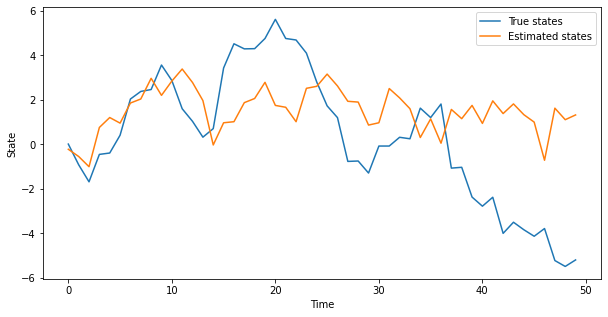

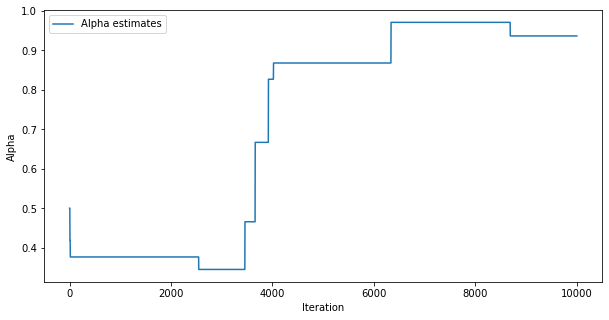

In [118]:
# Generate observations
true_states = [0]
observations = [g(true_states[0], sigma_w)]

for _ in range(1, T):
    true_states.append(f(true_states[-1], alpha, sigma_v))
    observations.append(g(true_states[-1], sigma_w))

observations = np.array(observations)

# Estimate the trajectory
state_estimates = particle_filter(observations, num_particles, alpha, sigma_v, sigma_w)

# Estimate alpha using MCMC
initial_alpha = 0.5
alphas = mcmc(observations, initial_alpha, num_particles, sigma_v, sigma_w)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(true_states, label='True states')
plt.plot(state_estimates, label='Estimated states')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(alphas, label='Alpha estimates')
plt.xlabel('Iteration')
plt.ylabel('Alpha')
plt.legend()
plt.show()

In [2]:
def BPF(initial_particles,f, likelihood, T, data, threshold):
    num_particles = initial_particles.shape[0]
    
    # Initialize varibles
    weights = np.zeros((num_particles, T))
    norm_weights = np.zeros((num_particles, T))
    particles = np.zeros((num_particles,T))
    ESS = np.zeros(T)
    
    # Time t=1
    particles[:,0] = initial_particles
    weights[:,0] = likelihood(data[0], particles[:,0] , 1.5)
    norm_weights[:,0] = weights[:,0] / weights[:,0].sum()
    ESS[0] = 1 / (norm_weights[:,0]**2).sum()

    # Time t > 1
    for t in range(1,T):
        #Propagate step
        particles[:, t] = f(particles[:, t - 1])
        # Update step: compute importance weights based on observation model
        incremental_weight = likelihood(data[t], particles[:,t] , 1.5)
        weights[:, t] = weights[:,t-1]*incremental_weight  
        norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
        
        #Adaptative Resampling
        ESS[t]= 1 / np.sum(norm_weights**2)
        if ESS[t] < num_particles*threshold:
            # Update particles and weights based on resampled indices
            resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, t])
            particles[:, t] = particles[resampled_indices, t]
            weights[:, t] = 1 / num_particles  # Reset weights to uniform distribution after resampling
            norm_weights[:, t] = weights[:,t] # Reset normalized weights
            
    return weights, norm_weights, particles, ESS

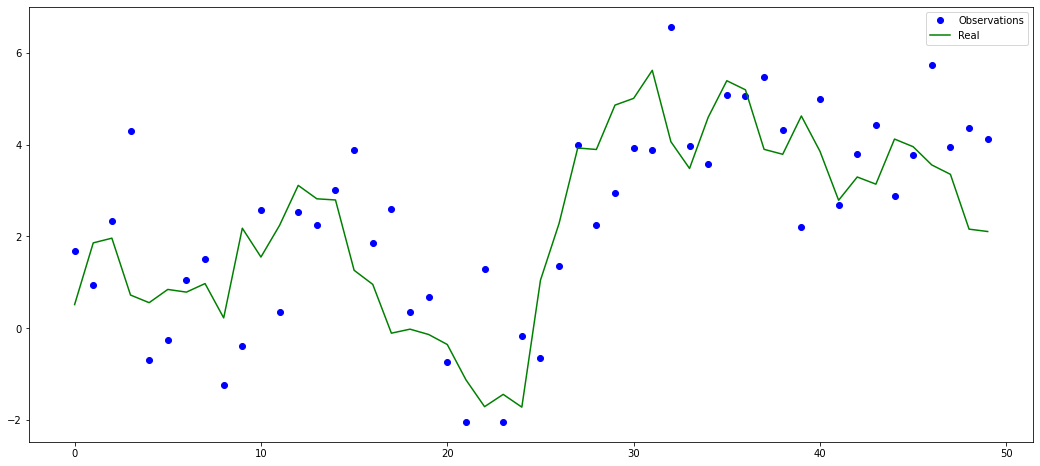

In [135]:
# Define parameters
alpha = 0.95
sigma_v = 1.0
sigma_w = 1.0

T = 50 # Define the number of time steps
time = np.arange(T) # Create a time vector 

# True object motion model
def f(x):
    return alpha*x + np.random.normal(0, sigma_v)

# Observation model
def g(x):
    return x + np.random.normal(0, sigma_w)

def likelihood(data, particles, sigma):
    return stats.norm.pdf(data, loc=particles, scale=sigma)

# Generate synthetic data
X_real = np.zeros(T)
Y_obs = np.zeros(T)
X_real[0] = np.random.normal(0, sigma_v)
Y_obs[0] = g(X_real[0])
for t in range(1, T):
    X_real[t] = f(X_real[t-1])
    Y_obs[t] = g(X_real[t-1])
    
plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, X_real, 'g', label='Real')
plt.legend()
plt.show()

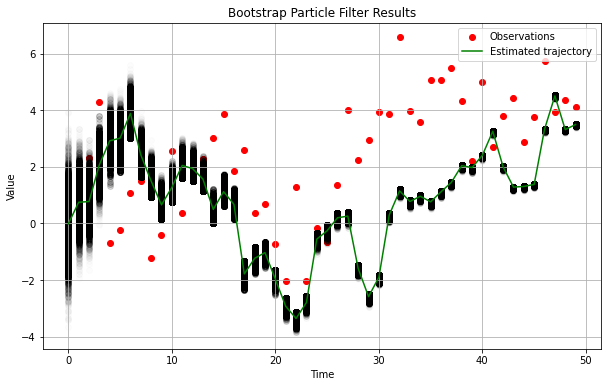

In [139]:
num_particles = 10000
T = 50 # Define the number of time steps

# Call the bootstrap particle filter function
weights, norm_weights, particles, ESS = BPF(np.random.normal(0, sigma_v, num_particles), f, likelihood, T, Y_obs, threshold=1)

# Plot the results
plt.figure(figsize=(10, 6))
#plt.plot(time, X_real, label='True trajectory', color='blue')
plt.scatter(time, Y_obs, label='Observations', color='red')
plt.plot(time, np.mean(particles, axis=0), label='Estimated trajectory', color='green')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Bootstrap Particle Filter Results')
plt.legend()
plt.grid(True)
# Plot particles
for t in range(T):
    plt.scatter(np.full(num_particles, t), particles[:, t], color='black', alpha=0.01)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Bootstrap Particle Filter Results')
plt.legend()
plt.grid(True)
plt.show()

# Synthetic SUIRD model for PF

In [17]:
def generate_synthetic_data(params, initial_state, N, num_days, noise_factor=0.1):
    alpha, beta, gamma, mu = params
    S, U, I, R, D = initial_state
    
    synthetic_data = np.zeros((num_days, 5))
    synthetic_data[0] = [S, U, I, R, D]
    
    for i in range(1, num_days):
        dS = -(beta * synthetic_data[i-1, 0] * synthetic_data[i-1, 1]) / N
        dU = (beta * synthetic_data[i-1, 0] * synthetic_data[i-1, 1]) / N - (alpha * synthetic_data[i-1, 1]) - (gamma * synthetic_data[i-1, 1]) - (mu * synthetic_data[i-1, 1])
        dI = alpha * synthetic_data[i-1, 1] - (gamma * synthetic_data[i-1, 2]) - (mu * synthetic_data[i-1, 2])
        dR = gamma * synthetic_data[i-1, 1] + (gamma * synthetic_data[i-1, 2])
        dD = mu * synthetic_data[i-1, 1] + (mu * synthetic_data[i-1, 2])
        
        # Simulate noisy observations by adding noise to the true counts
        noise_I = np.random.normal(0, noise_factor * synthetic_data[i-1, 2])
        noise_D = np.random.normal(0, noise_factor * synthetic_data[i-1, 4])
        
        S_n = synthetic_data[i-1, 0] + dS
        U_n = synthetic_data[i-1, 1] + dU 
        I_n = synthetic_data[i-1, 2] + dI + noise_I
        R_n = synthetic_data[i-1, 3] + dR
        D_n = synthetic_data[i-1, 4] + dD + noise_D
        
        synthetic_data[i] = [S_n, U_n, I_n, R_n, D_n]
    
    return synthetic_data

# Example usage
params = (0.1, 0.2, 0.05, 0.01)  # Example parameters
initial_state = [990, 10, 0, 0, 0]  # Example initial state [S, U, I, R, D]
N = 1000  # Example population size
num_days = 100  # Example number of days
noise_factor = 0.05  # Example noise factor

synthetic_data = generate_synthetic_data(params, initial_state, N, num_days, noise_factor)


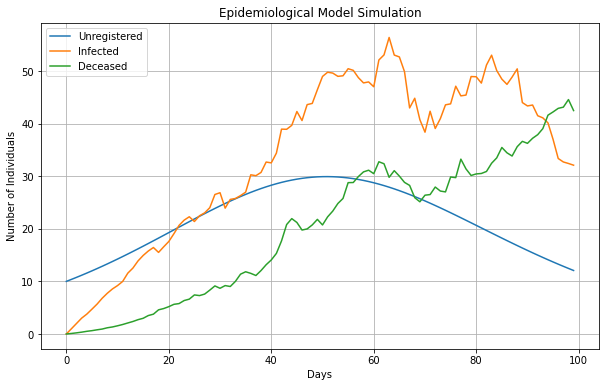

In [18]:
def plot_epidemiological_data(synthetic_data):
    days = range(len(synthetic_data))
    S = synthetic_data[:, 0]
    U = synthetic_data[:, 1]
    I_obs = synthetic_data[:, 2]
    R = synthetic_data[:, 3]
    D_obs = synthetic_data[:, 4]
    
    plt.figure(figsize=(10, 6))
    #plt.plot(days, S, label='Susceptible')
    plt.plot(days, U, label='Unregistered')
    plt.plot(days, I_obs, label='Infected')
    #plt.plot(days, R, label='Recovered')
    plt.plot(days, D_obs, label='Deceased')
    plt.title('Epidemiological Model Simulation')
    plt.xlabel('Days')
    plt.ylabel('Number of Individuals')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_epidemiological_data(synthetic_data)


In [127]:
def SUIRD_transition(params, previous_state, N):
    alpha, beta, gamma, mu= params
    S, U, I, R, D = previous_state

    dS = -(beta * S * U)/ N
    dU =  (beta * S * U)/ N - (alpha * U) - (gamma * U) - (mu * U)
    dI = alpha * U - (gamma * I) - (mu * I)
    dR = gamma * U + (gamma * I)
    dD = mu * U + (mu * I)
    
    # Simulate noisy observations by adding noise to the true counts
    noise_I = np.random.normal(0, 0.05*I)
    noise_D = np.random.normal(0, 0.05*D)
    
    S_n = S + dS
    U_n = U + dU
    I_n = I + dI + noise_I
    R_n = R+  dR
    D_n = D + dD + noise_D

    return np.array([S_n, U_n, I_n, R_n, D_n]).T

def likelihood(U, I, death_rate, data):
    # Assuming death_rate is a parameter controlling the rate of deaths
    
    mean_deaths = death_rate * (U + I)
    return stats.poisson(mean_deaths).pmf(data)

def likelihood(U, I, death_rate, dispersion, data):
    # Assuming death_rate is a parameter controlling the rate of deaths
    mean_deaths = death_rate * (U + I)
    p = dispersion / (mean_deaths+dispersion)
    return stats.nbinom(dispersion,p).pmf(data)


In [140]:
num_particles = 1000
num_days = 100
num_states = 5

params = (0.1, 0.2, 0.05, 0.01)  # Example parameters
N = 1000  # Example population size

# Initialize Particles
particles = np.zeros((num_particles, num_days, num_states))
weights = np.zeros((num_particles, num_days))
norm_weights = np.zeros((num_particles, num_days))
ESS_SIR = np.zeros(num_days)

U = stats.uniform(1,10).rvs(num_particles)
S = N - U
I = np.zeros(num_particles)
R = np.zeros(num_particles)
D = np.zeros(num_particles)

D_obs = synthetic_data[:, 4]
I_obs = synthetic_data[:, 2]

# Time t=1
particles[:,0,:] = np.array([S, U, I, R, D]).T
weights[:,0] = likelihood(particles[:,0,1], particles[:,0,2], 0.01, 100, np.round(D_obs[0]))
norm_weights[:,0] = weights[:,0] / weights[:,0].sum()
ESS_SIR[0] = 1 / (norm_weights[:,0]**2).sum()

# Time t > 1
for t in range(1,num_days):
    # Predict step: propagate particles forward using motion model
    for k in range(0,num_particles):
        particles[k,t,:] = SUIRD_transition(params, particles[k,t-1,:], N)

    # Update step: compute importance weights based on observation model
    incremental_weight = likelihood(particles[:,t,1], particles[:,t,2], 0.01,100, np.round(D_obs[t]))
    weights[:, t] = weights[:,t-1]*incremental_weight  
    norm_weights[:, t] = weights[:,t] / weights[:,t].sum()
    
    ESS_SIR[t]= 1 / np.sum(norm_weights**2)
    if ESS_SIR[t] < 0:
        resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, t])
        particles[:, t,:] = particles[resampled_indices, t,:]
        weights[:, t] = 1 / num_particles  # Reset weights to uniform distribution after resampling
        norm_weights[:, t] = weights[:,t]
        # Compute estimated state (weighted mean of particles)

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_67130/1219788936.py:38: RuntimeWarning: invalid value encountered in true_divide
  norm_weights[:, t] = weights[:,t] / weights[:,t].sum()


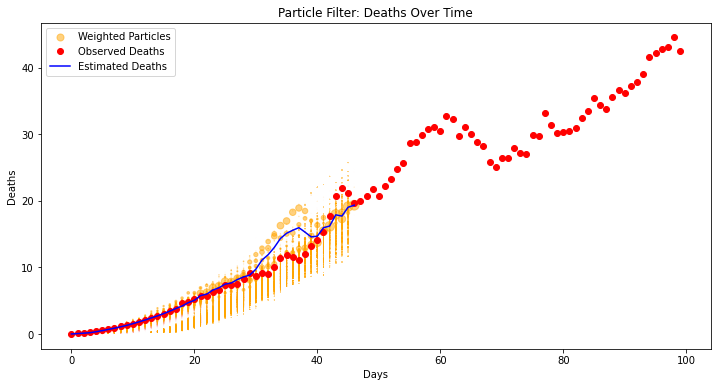

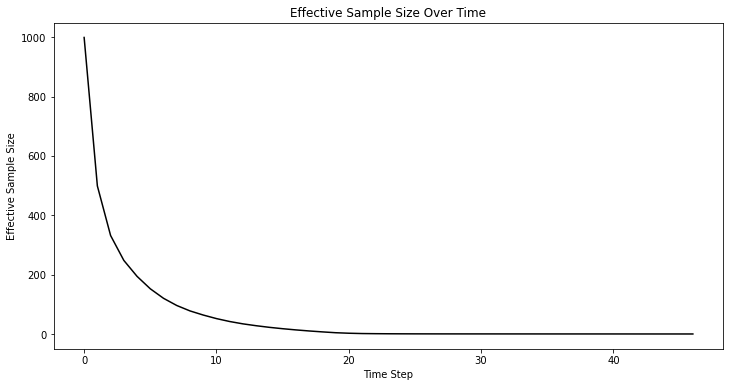

In [141]:
# Estimate the state variables (mean of particles weighted by normalized weights)
estimated_deaths = np.sum(particles[:, :, 4] * norm_weights, axis=0)

# Plot weighted particles
time = np.arange(num_days)
plt.figure(figsize=(12, 6))
for t in range(num_days):
    sizes = 100 * norm_weights[:, t]  # Use weights to determine marker size (scaled for better visibility)
    plt.scatter([time[t]] * num_particles, particles[:, t, 4], s=sizes, c='orange', alpha=0.5)

plt.scatter([], [], s=50, c='orange', alpha=0.5, label='Weighted Particles')
plt.plot(time, D_obs, 'ro', label='Observed Deaths')
plt.plot(time, estimated_deaths, 'b-', label='Estimated Deaths')
plt.xlabel('Days')
plt.ylabel('Deaths')
plt.legend()
plt.title('Particle Filter: Deaths Over Time')
plt.show()

# Plot ESS in a separate chart
plt.figure(figsize=(12, 6))
plt.plot(range(0,num_days), ESS_SIR, color='black')
plt.xlabel('Time Step')
plt.ylabel('Effective Sample Size')
plt.title('Effective Sample Size Over Time')
plt.show()


# PMCMC Attempt at the same problem above

In [92]:
def SUIRD_transition(params, previous_state, N):
    # Unpack previous state
    S, U, I, R, D = previous_state
    
    # Extract parameters
    beta, gamma, delta, mu = params
    
    # Compute transition rates
    infection_rate = beta * I * S / N
    recovery_rate = gamma * I
    death_rate = delta * I
    
    # Compute transitions
    new_S = S - infection_rate
    new_U = U + infection_rate - death_rate
    new_I = I + infection_rate - recovery_rate - death_rate
    new_R = R + recovery_rate
    new_D = D + death_rate
    
    # Add noise to infected and deceased counts
    noise_I = np.random.normal(0, 0.05 * I)
    noise_D = np.random.normal(0, 0.05 * D)
    new_I += noise_I
    new_D += noise_D
    
    # Ensure non-negative counts
    new_S = max(new_S, 0)
    new_U = max(new_U, 0)
    new_I = max(new_I, 0)
    new_R = max(new_R, 0)
    new_D = max(new_D, 0)
    
    # Return new state
    return new_S, new_U, new_I, new_R, new_D

In [106]:
from scipy.stats import uniform

# Define priors for parameters
prior_beta = uniform(0, 1)  # Example: beta ~ Uniform(0, 1)
prior_gamma = uniform(0, 1)  # Example: gamma ~ Uniform(0, 1)
prior_delta = uniform(0, 0.1)  # Example: delta ~ Uniform(0, 0.1)
prior_mu = uniform(0, 0.05)  # Example: mu ~ Uniform(0, 0.05)

def propose_params(current_params, step_size):
    return current_params + step_size * np.random.randn(len(current_params))

def particle_filter(params, N, synthetic_data):
    num_particles = 100
    num_days = synthetic_data.shape[0]
    num_states = 5

    particles = np.zeros((num_particles, num_days, num_states))
    weights = np.zeros((num_particles, num_days))
    norm_weights = np.zeros((num_particles, num_days))
    ESS_SIR = np.zeros(num_days)

    U = np.random.uniform(1, 10, num_particles)
    S = N - U
    I = np.zeros(num_particles)
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)

    D_obs = synthetic_data[:, 4]
    I_obs = synthetic_data[:, 2]

    particles[:, 0, :] = np.array([S, U, I, R, D]).T
    weights[:, 0] = likelihood(particles[:, 0, 1], particles[:, 0, 2], 0.01, 50, np.round(D_obs[0]))
    norm_weights[:, 0] = weights[:, 0] / weights[:, 0].sum()
    ESS_SIR[0] = 1 / (norm_weights[:, 0]**2).sum()

    log_likelihood = np.log(weights[:, 0].sum())

    for t in range(1, num_days):
        for k in range(num_particles):
            particles[k, t, :] = SUIRD_transition(params, particles[k, t-1, :], N)

        incremental_weight = likelihood(particles[:, t, 1], particles[:, t, 2], 0.01, 50, np.round(D_obs[t]))
        weights[:, t] = weights[:, t-1] * incremental_weight
        norm_weights[:, t] = weights[:, t] / weights[:, t].sum()
        log_likelihood += np.log(weights[:, t].sum())

        ESS_SIR[t] = 1 / np.sum(norm_weights[:, t]**2)
        if ESS_SIR[t] < num_particles / 4:
            resampled_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=norm_weights[:, t])
            particles[:, t, :] = particles[resampled_indices, t, :]
            weights[:, t] = 1 / num_particles
            norm_weights[:, t] = weights[:, t]

    return log_likelihood

def pMCMC(synthetic_data, N, num_iterations, initial_params, step_size):
    current_params = np.array(initial_params)
    current_log_likelihood = particle_filter(current_params, N, synthetic_data)
    
    samples = [current_params]
    log_likelihoods = [current_log_likelihood]

    for i in range(num_iterations):
        proposed_params = propose_params(current_params, step_size)
        proposed_log_likelihood = particle_filter(proposed_params, N, synthetic_data)
        
        acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)
        
        if np.random.rand() < acceptance_ratio:
            current_params = proposed_params
            current_log_likelihood = proposed_log_likelihood
        
        samples.append(current_params)
        log_likelihoods.append(current_log_likelihood)
        
    return np.array(samples), np.array(log_likelihoods)

# Example usage
initial_params = [0.05, 0.3, 0.08, 0.05]  # Initial guess for parameters
step_size = [0.2, 0.2, 0.2, 0.2]  # Step size for proposing new parameters
num_iterations = 100  # Number of MCMC iterations

samples, log_likelihoods = pMCMC(synthetic_data, N, num_iterations, initial_params, step_size)

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_67130/2899660092.py:44: RuntimeWarning: invalid value encountered in true_divide
  norm_weights[:, t] = weights[:, t] / weights[:, t].sum()
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_67130/2899660092.py:45: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(weights[:, t].sum())
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_67130/2899660092.py:67: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = np.exp(proposed_log_likelihood - current_log_likelihood)


In [110]:
log_likelihoods

array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
       -inf, -inf])

In [107]:
samples

array([[0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.05, 0.3 , 0.08, 0.05],
       [0.

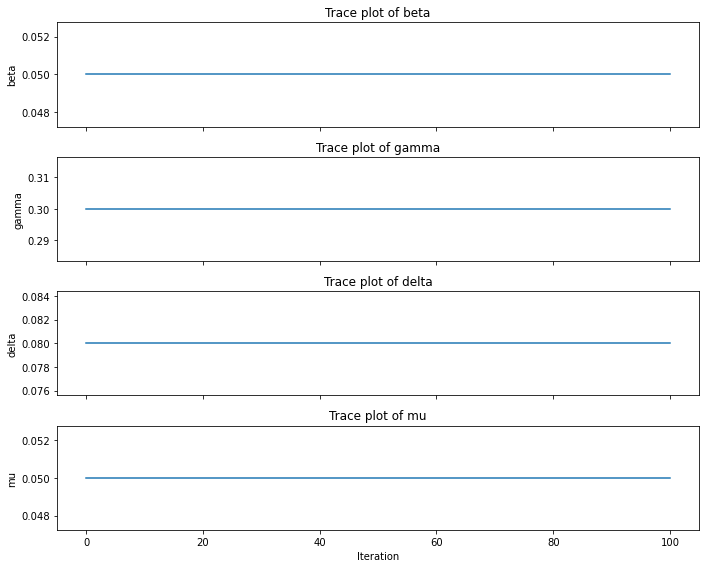

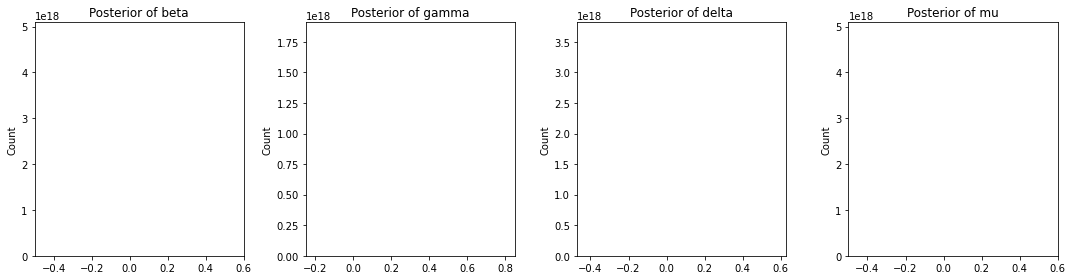

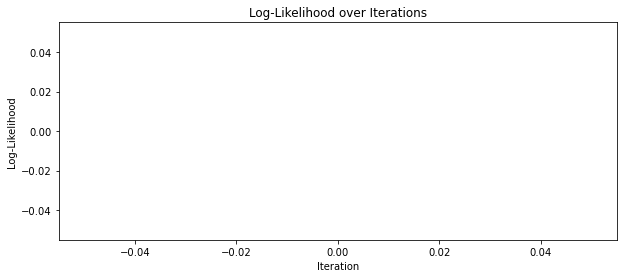

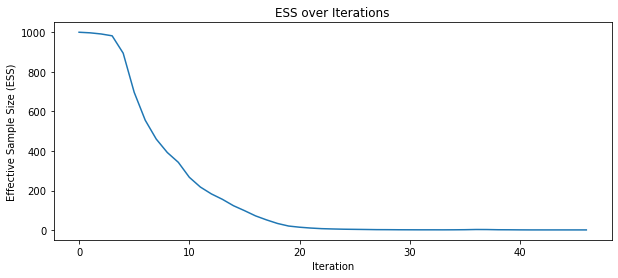

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `samples` is a NumPy array with shape (num_iterations, num_params)
# and `log_likelihoods` is a NumPy array with shape (num_iterations,)

# Define parameter names for better readability in plots
param_names = ['beta', 'gamma', 'delta', 'mu']

# 1. Trace plots
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 8), sharex=True)
for i, param in enumerate(param_names):
    axes[i].plot(samples[:, i])
    axes[i].set_ylabel(param)
    axes[i].set_title(f'Trace plot of {param}')
axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()

# 2. Parameter distributions
fig, axes = plt.subplots(1, len(param_names), figsize=(15, 4))
for i, param in enumerate(param_names):
    sns.histplot(samples[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Posterior of {param}')
plt.tight_layout()
plt.show()

# 3. Log-likelihood over iterations
plt.figure(figsize=(10, 4))
plt.plot(log_likelihoods)
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood over Iterations')
plt.show()

# 4. Effective Sample Size (ESS) over iterations
def calculate_ess(weights):
    return 1 / np.sum(weights ** 2)

ess = np.array([calculate_ess(norm_weights[:, t]) for t in range(norm_weights.shape[1])])
plt.figure(figsize=(10, 4))
plt.plot(ess)
plt.xlabel('Iteration')
plt.ylabel('Effective Sample Size (ESS)')
plt.title('ESS over Iterations')
plt.show()
